In [1]:
#  --------- Import Libraries --------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn import svm
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# --------- Functions ----------------


def hyperparameterSearch(knn_models, name):
    fig, ax = plt.subplots(1,1) 
    ax.plot(knn_models.index, knn_models['mean_train_score'],color = 'steelblue', alpha = 0.5)
    ax.plot(knn_models.index, knn_models['mean_test_score'],color = 'salmon', alpha = 0.5)
    ax.scatter(knn_models.index, knn_models['mean_train_score'], s = 50,
               color = 'steelblue', edgecolor = 'black',label = 'Train Data')
    ax.scatter(knn_models.index, knn_models['mean_test_score'], s = 50,
               color = 'salmon', edgecolor = 'black', label = 'Validation Data')
    ax.set_ylabel('ROC AUC Score')
    ax.set_xlabel('Model Parameters')
    ax.set_title('Grid Search - Hyperparameters '+name)
    plt.grid()
    plt.legend()
    display(knn_models.params.head())
    knn_models['params_1'] = knn_models.params.astype(str).str.split(':').str[1].astype(str).str.split(',').str[0].str.replace("'","").str.replace('{','').str.replace('}','')
    knn_models['params_2'] = knn_models.params.astype(str).str.split(':').str[-1].astype(str).str.replace("'","").str.replace('{','').str.replace('}','')
    knn_models['params_str'] = knn_models['params_1'].astype(str) + ',' + knn_models['params_2'].astype(str)
    strings = knn_models['params_str'].to_list()
    #print(knn_models.params_1.head())
    x = np.arange(0,len(strings))
    ax.set_xticks(x)
    ax.set_xticklabels(strings, rotation=45, fontsize=10)
    plt.show()
    fig.savefig(name+'hyperparameter.png')
    
def cvPlot(results,name,tpye):
    f, axes = plt.subplots(2, 3,sharey=True,figsize = (8,6))
    f.suptitle(name)

    x = np.arange(0,len(results['train_accuracy']))

    axes[0, 0].bar(x-0.2, results['train_accuracy'], width=0.2, color='grey', align='center',edgecolor = 'black', label = 'Train')
    axes[0, 0].bar(x, results['test_accuracy'], width=0.2, color='steelblue', align='center',edgecolor = 'black',label = 'Test')
    axes[0, 0].set_title('Accuracy CV5')
    axes[0, 0].legend(loc="upper right")

    axes[0, 1].bar(x-0.2, results['train_precision'], width=0.2, color='grey', align='center',edgecolor = 'black', label = 'Train')
    axes[0, 1].bar(x, results['test_precision'], width=0.2, color='olive', align='center',edgecolor = 'black',label = 'Test')
    axes[0, 1].set_title('Precision CV5')
    axes[0, 1].legend(loc="upper right")

    axes[0, 2].bar(x-0.2, results['train_recall'], width=0.2, color='grey', align='center',edgecolor = 'black', label = 'Train')
    axes[0, 2].bar(x, results['test_recall'], width=0.2, color='mediumpurple', align='center',edgecolor = 'black',label = 'Test')
    axes[0, 2].set_title('Recall CV5')
    axes[0, 2].legend(loc="upper right")

    axes[1, 0].bar(x-0.2, results['train_f1'], width=0.2, color='grey', align='center',edgecolor = 'black', label = 'Train')
    axes[1, 0].bar(x, results['test_f1'], width=0.2, color='gold', align='center',edgecolor = 'black',label = 'Test')
    axes[1, 0].set_title('F1 CV5')
    axes[1, 0].legend(loc="upper right")

    axes[1, 1].bar(x-0.2, results['train_roc_auc'], width=0.2, color='grey', align='center',edgecolor = 'black', label = 'Train')
    axes[1, 1].bar(x, results['test_roc_auc'], width=0.2, color='salmon', align='center',edgecolor = 'black',label = 'Test')
    axes[1, 1].set_title('ROC AUC CV5')
    axes[1, 1].legend(loc="upper right")

    axes[1, 2].axis('off')
    plt.legend
    plt.tight_layout()
    plt.ylim([0,1])
    f.savefig(name+'_'+tpye+'.png')
    plt.show()
    
def one_hot_encoding(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column],prefix = prefix)
    df = pd.concat([df,dummies], axis = 1)
    df = df.drop( column, axis = 1)
    return(df)
    
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

#-------------
    
    
# Read audiofeatures csv
df = pd.read_csv('merged_original_and_audiofeatures.csv')

# Groupby Number of Streams by Track Name and sum them -> Total Number of Streams
df['T_Streams'] = df.groupby(['Track Name'])['Streams'].transform("sum")

df = df.drop_duplicates(subset = ['Track Name'])
    
drop_columns = ['Unnamed: 0.1','Position','country','Date',
               'URL','sub_region','intermediate-region','id',
               'Unnamed: 0','uri','track_href','analysis_url',
                'type','loudness','mode','time_signature']

df = df.drop(drop_columns, axis = 1)

#--------  ONE HOT ENCODING --------

df = df.drop(['Artist'], axis = 1)
df = one_hot_encoding(df ,'key','key')
df_t = df.copy()

#Create popularity proxy
df_t['Popularity_Proxy'] = pd.qcut(df_t['T_Streams'], q = 2, labels = [0,1])

#----------
drop_columns_t = ['Track Name','T_Streams',
                 'country_name','region']

df_t = df_t.drop(drop_columns_t, axis = 1)

df_t = clean_dataset(df_t)
df_t = df_t.reset_index()

y = df_t.loc[:,'Popularity_Proxy']
X = df_t.drop(['Popularity_Proxy','Streams'], axis = 1)

print('Original Shapes',X.shape,y.shape)

keep_Columns = ['danceability','energy','speechiness',
                'acousticness','instrumentalness','liveness',
                'valence','tempo','duration_ms'] 


# ---------
#Create X, Y VAL Sets
X_, X_val, y_, y_val = train_test_split(X,y,train_size = 0.8, random_state = 20)
# ----------
print('After train_test_split Shapes',X_.shape,y_.shape)
# FIT - SCALING TRAIN 
# Avoid scaling one hot encoded keys
XX = X_.copy()
XX = XX[keep_Columns]
X_ = X_.drop(keep_Columns, axis = 1)
scaler = StandardScaler()
XX = scaler.fit_transform(XX)
XX = pd.DataFrame(XX, columns = keep_Columns)
X_ = X_.reset_index().drop(['index'], axis = 1)
X_ = pd.concat([X_,XX], axis = 1)
y_ = y_.reset_index(drop = True)
print(':______________:')
try:
    X_ = X_.drop(['level_0'], axis = 1)
    print('pre final Shapes',X_.shape,y_.shape)
except:
    print('Could not drop X_ index')
#---------------------
# SCALING TEST FROM FIT TRAIN
# Avoid scaling one hot encoded keys
XX = X_val.copy()
XX = XX[keep_Columns]
X_val = X_val.drop(keep_Columns, axis = 1)
XX = scaler.fit_transform(XX)
#XX = scaler.transform(XX)
XX = pd.DataFrame(XX, columns = keep_Columns)
X_val = X_val.reset_index().drop(['index'], axis = 1)
X_val = pd.concat([X_val,XX], axis = 1)
y_val = y_val.reset_index(drop = True)

try:
    X_val = X_val.drop(['level_0'], axis = 1)
except:
    print('Could not drop X_val index')

    
print('final Shapes',X_.shape,y_.shape)
print('X Data\n')
display(X_.head())
print('Y Data\n')
display(y_.head())

/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:111: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_original_and_audiofeatures.csv')


Original Shapes (18593, 22) (18593,)
After train_test_split Shapes (14874, 22) (14874,)
:______________:
pre final Shapes (14874, 21) (14874,)
final Shapes (14874, 21) (14874,)
X Data



,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,key_11,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.821285,-1.819327,-0.600916,1.570426,-0.176490,-0.652347,0.691760,-0.316283,-2.104748
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.073710,0.956681,-0.298209,-1.024831,-0.176476,-0.695702,0.609997,-0.458510,-0.428955
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.075488,-1.289829,-0.655366,0.442370,-0.176490,-0.099218,0.962872,-1.364696,-0.076134
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,-2.380526,-0.199989,-0.582458,0.224037,8.910350,-0.288023,0.188267,1.773018,-1.643290
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.292921,-0.621531,2.844217,1.337537,-0.176490,1.558070,-0.267890,-0.248046,-0.339647


Y Data



0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Popularity_Proxy, dtype: float64

------------ TEST BASELINE ---------------

Init Models
-------------------------------------------------------------
Logistic Regression


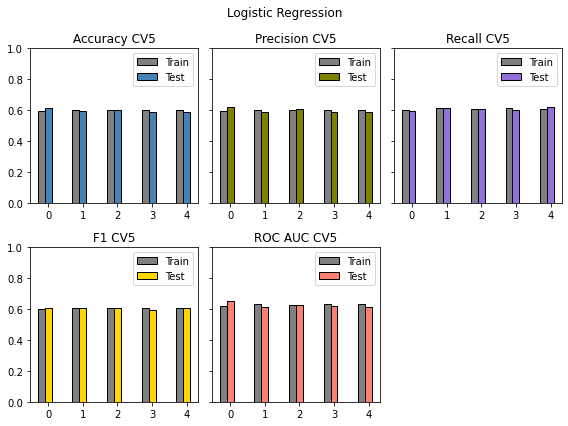

-------------------------------------------------------------
K-Nearest-Neighbors


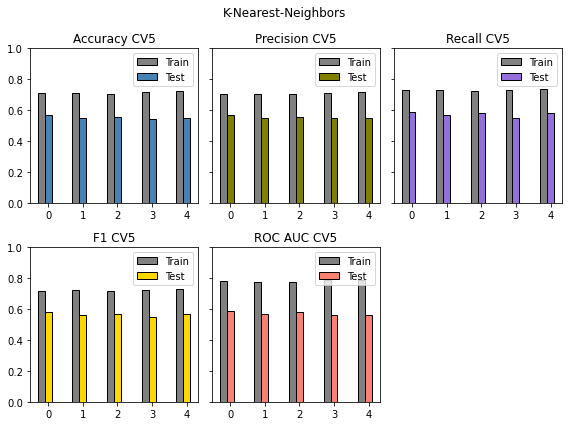

-------------------------------------------------------------
RandomForest


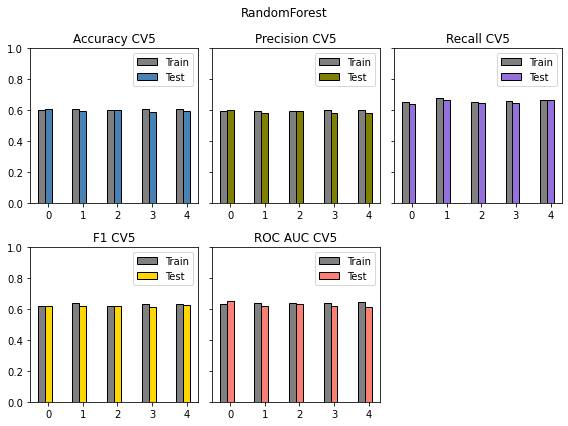

-------------------------------------------------------------
SupportVectorMachine


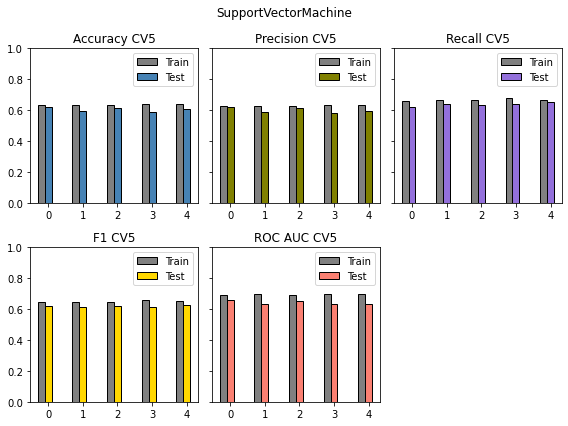

In [2]:
# -------------- TEST BASELINE -------------------
# MODELS: LogisticRegression 
#         KNeighbors
#         RandomForest
#         SVM
# -------------- TEST BASELINE -------------------
print('------------ TEST BASELINE ---------------\n')

# Init models
print('Init Models')
log_model = LogisticRegression()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(max_depth=2, random_state=0)
svm_model = SVC()


models = [log_model,knn_model,rf_model, svm_model]

models_string = ['Logistic Regression',
                 'K-Nearest-Neighbors','RandomForest',
                 'SupportVectorMachine']

_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

model_dic = {}
for i in models_string: #Initialize model_dic
    model_dic[i] = ''
    
for i in range(len(models)):
    
    model = models[i]
    name = models_string[i]
    print('-------------------------------------------------------------')
    print(name)
    
    # Cross validation CV 5, estimator - model
    results = cross_validate(estimator=model,
                           X=X_,
                           y=y_,
                           cv=5,
                           scoring=_scoring,
                           return_train_score=True)
    model_dic[name] = results
    
    results = pd.DataFrame(results)
    results.to_csv(name.replace('','_')+'_baseline.csv')
    
    cvPlot(results,name,'Baseline')



In [3]:
# SAVE MODELS BASELINES
# For Plots later

knn = pd.read_csv('_K_-_N_e_a_r_e_s_t_-_N_e_i_g_h_b_o_r_s__baseline.csv')
SVM = pd.read_csv('_S_u_p_p_o_r_t_V_e_c_t_o_r_M_a_c_h_i_n_e__baseline.csv')
rf = pd.read_csv('_R_a_n_d_o_m_F_o_r_e_s_t__baseline.csv')
Log = pd.read_csv('_L_o_g_i_s_t_i_c_ _R_e_g_r_e_s_s_i_o_n__baseline.csv')

models = [Log,knn,rf, SVM]
models_names = ['LR','KNN','RF','SVM']

sub_model_dic = {'Model': [],
                'test_accuracy': [],
                'train_accuracy': [],
                'test_precision': [],
                'train_precision': [],
                'test_recall': [],
                'train_recall': [],
                'test_f1': [],
                'train_f1': [],
                'test_roc_auc': [],
                'train_roc_auc': [],}

for i in range(len(models_names)):
    
    sub_model_dic['Model'].append(models_names[i])
    sub_model_dic['test_accuracy'].append(models[i]['test_accuracy'].mean())
    sub_model_dic['train_accuracy'].append(models[i]['train_accuracy'].mean())
    sub_model_dic['test_precision'].append(models[i]['test_precision'].mean())
    sub_model_dic['train_precision'].append(models[i]['train_precision'].mean())
    sub_model_dic['test_recall'].append(models[i]['test_recall'].mean())
    sub_model_dic['train_recall'].append(models[i]['train_recall'].mean())
    sub_model_dic['test_f1'].append(models[i]['test_f1'].mean())
    sub_model_dic['train_f1'].append(models[i]['train_f1'].mean())
    sub_model_dic['test_roc_auc'].append(models[i]['test_roc_auc'].mean())
    sub_model_dic['train_roc_auc'].append(models[i]['train_roc_auc'].mean())
    
model_df = pd.DataFrame(sub_model_dic)#.set_index('Model')


model_df.to_csv('Models_baseline.csv')
display(model_df)

,Model,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,LR,0.598023,0.599906,0.598483,0.600070,0.608249,0.609319,0.603164,0.604654,0.624233,0.627437
1,KNN,0.554390,0.713745,0.554264,0.708128,0.574777,0.731423,0.564296,0.719586,0.569962,0.780178
2,RF,0.596006,0.604629,0.588181,0.595655,0.653369,0.662036,0.618928,0.627064,0.626401,0.638428
3,SVM,0.604478,0.635538,0.600427,0.629376,0.637303,0.666923,0.618102,0.647600,0.638259,0.694743


--------- Logistic Regression Model ---------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.044586,0.025667,0.004194,0.002315,0.1,100,"{'C': 0.1, 'max_iter': 100}",0.649890,0.611392,0.627587,...,0.624323,0.013884,1,0.621159,0.630853,0.627057,0.628489,0.629699,0.627452,0.003390
1,0.020025,0.001864,0.002186,0.000113,0.1,500,"{'C': 0.1, 'max_iter': 500}",0.649890,0.611392,0.627587,...,0.624323,0.013884,1,0.621159,0.630853,0.627057,0.628489,0.629699,0.627452,0.003390
2,0.017761,0.002004,0.002437,0.000430,0.25,100,"{'C': 0.25, 'max_iter': 100}",0.649806,0.611361,0.627522,...,0.624263,0.013867,3,0.621142,0.630854,0.627040,0.628474,0.629702,0.627442,0.003396
3,0.018964,0.000964,0.002276,0.000200,0.25,500,"{'C': 0.25, 'max_iter': 500}",0.649806,0.611361,0.627522,...,0.624263,0.013867,3,0.621142,0.630854,0.627040,0.628474,0.629702,0.627442,0.003396
4,0.018515,0.001742,0.002159,0.000177,0.5,100,"{'C': 0.5, 'max_iter': 100}",0.649774,0.611355,0.627483,...,0.624238,0.013860,5,0.621136,0.630852,0.627039,0.628471,0.629704,0.627440,0.003398


0     {'C': 0.1, 'max_iter': 100}
1     {'C': 0.1, 'max_iter': 500}
2    {'C': 0.25, 'max_iter': 100}
3    {'C': 0.25, 'max_iter': 500}
4     {'C': 0.5, 'max_iter': 100}
Name: params, dtype: object

/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:45: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_1'] = knn_models.params.astype(str).str.split(':').str[1].astype(str).str.split(',').str[0].str.replace("'","").str.replace('{','').str.replace('}','')
/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:46: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_2'] = knn_models.params.astype(str).str.split(':').str[-1].astype(str).str.replace("'","").str.replace('{','').str.replace('}','')


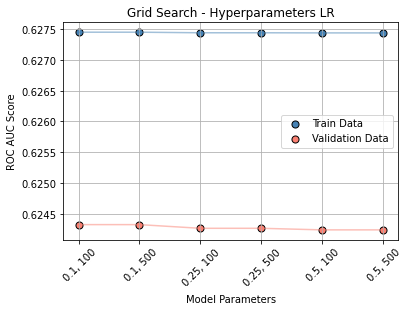

clf.best_score_ 0.6243229766573887
clf.best_params_ {'C': 0.1, 'max_iter': 100}


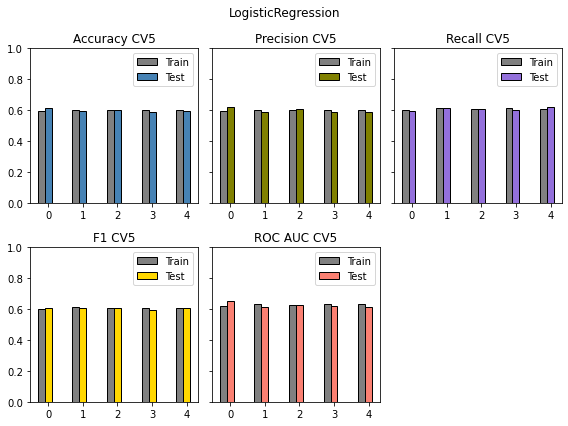

LR Final Model LogisticRegression(C=0.5)


In [4]:
# --------- GRID SEARCH LR -------------
print('--------- Logistic Regression Model ---------')
log_model = LogisticRegression()
parameters = {'max_iter':[100,500], 'C':[0.1,0.25,0.5]}
clf = GridSearchCV(log_model, parameters,return_train_score = True, scoring ='roc_auc')
clf.fit(X_, y_)

logistic = pd.DataFrame(clf.cv_results_)
logistic.to_csv('Logistic_Grid_Search.csv')
display(logistic.head())
hyperparameterSearch(logistic, 'LR')

print('clf.best_score_',clf.best_score_)
print('clf.best_params_',clf.best_params_)

model = LogisticRegression(max_iter = 100,C = 0.5)

results = cross_validate(estimator=model,
                           X=X_,
                           y=y_,
                           cv=5,
                           scoring=_scoring,
                           return_train_score=True,return_estimator = True)

results_log = pd.DataFrame(results)
#display(results_log.head())
results_log.to_csv('Logistic_regression_gridSearch_Opt_results.csv')

cvPlot(results_log,'LogisticRegression','Hyperparameter')
model_lr = results['estimator'][0]
print('LR Final Model',model_lr)


--------- Random Forest Model ---------


0     {'max_depth': 6, 'max_features': 'sqrt'}
1     {'max_depth': 6, 'max_features': 'log2'}
2    {'max_depth': 12, 'max_features': 'sqrt'}
3    {'max_depth': 12, 'max_features': 'log2'}
4    {'max_depth': 24, 'max_features': 'sqrt'}
Name: params, dtype: object

/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:45: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_1'] = knn_models.params.astype(str).str.split(':').str[1].astype(str).str.split(',').str[0].str.replace("'","").str.replace('{','').str.replace('}','')
/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:46: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_2'] = knn_models.params.astype(str).str.split(':').str[-1].astype(str).str.replace("'","").str.replace('{','').str.replace('}','')


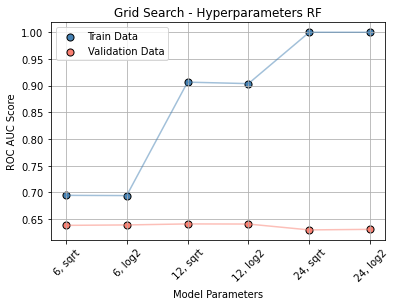

clf.best_score_ 0.6410820546814335
clf.best_params_ {'max_depth': 12, 'max_features': 'sqrt'}


,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.696774,0.043203,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.626891,0.636608,0.628686,0.632398,0.627845,0.659916,0.628265,0.645864,0.665201,0.692467
1,0.685295,0.042938,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.600672,0.638541,0.595625,0.632061,0.637885,0.670460,0.616031,0.650694,0.629767,0.695379
2,0.689492,0.043227,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.617815,0.638289,0.614644,0.632262,0.640562,0.668452,0.627335,0.649854,0.645273,0.693444
3,0.699407,0.042579,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.595630,0.641903,0.591567,0.636335,0.629183,0.669456,0.609796,0.652475,0.629183,0.695336
4,0.668904,0.042300,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.598521,0.643697,0.594560,0.640726,0.629605,0.661312,0.611581,0.650856,0.622949,0.698119


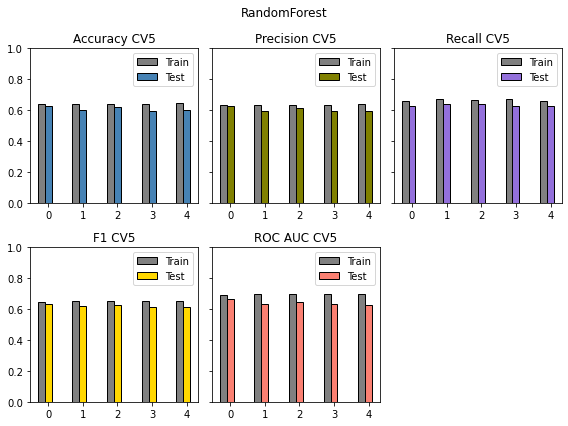

RF Final model RandomForestClassifier(max_depth=6, max_features='sqrt')


In [5]:
# --------- GRID SEARCH RF -------------
print('--------- Random Forest Model ---------')
model = RandomForestClassifier()
parameters = {'max_features':('sqrt','log2'), 'max_depth':[6,12,24]}
clf = GridSearchCV(model, parameters,return_train_score = True, scoring = 'roc_auc')
clf.fit(X_, y_)

logistic = pd.DataFrame(clf.cv_results_)
logistic.to_csv('RF_Grid_Search.csv')
hyperparameterSearch(logistic, 'RF')

print('clf.best_score_',clf.best_score_)
print('clf.best_params_',clf.best_params_)

model = RandomForestClassifier(max_features = 'sqrt', max_depth = 6)

results = cross_validate(estimator=model,
                           X=X_,
                           y=y_,
                           cv=5,
                           scoring=_scoring,
                           return_train_score=True,return_estimator = True)

rf_results = pd.DataFrame(results)
display(rf_results.head())
rf_results.to_csv('RF_regression_gridSearch_Opt_results.csv')
cvPlot(rf_results,'RandomForest','Hyperparameter')

model_rf = results['estimator'][0]
print('RF Final model', model_rf)


--------- KNeighbor Model ---------


0     {'n_neighbors': 25, 'weights': 'uniform'}
1    {'n_neighbors': 25, 'weights': 'distance'}
2     {'n_neighbors': 50, 'weights': 'uniform'}
3    {'n_neighbors': 50, 'weights': 'distance'}
4    {'n_neighbors': 100, 'weights': 'uniform'}
Name: params, dtype: object

/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:45: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_1'] = knn_models.params.astype(str).str.split(':').str[1].astype(str).str.split(',').str[0].str.replace("'","").str.replace('{','').str.replace('}','')
/var/folders/jl/rgcr44594412s1t2tj10yfmm0000gp/T/ipykernel_49564/4224241191.py:46: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  knn_models['params_2'] = knn_models.params.astype(str).str.split(':').str[-1].astype(str).str.replace("'","").str.replace('{','').str.replace('}','')


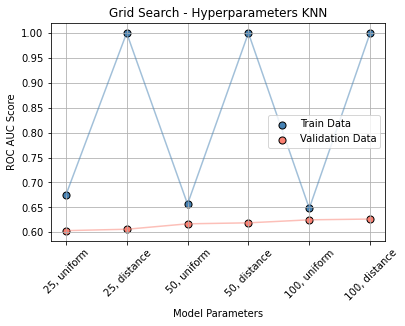

clf.best_score_ 0.6266035382669649
clf.best_params_ {'n_neighbors': 100, 'weights': 'distance'}


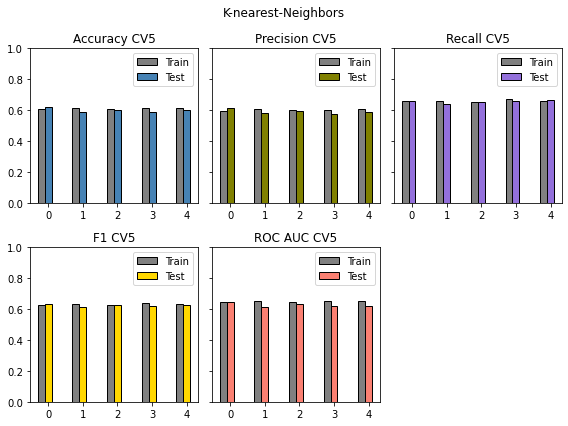

knn final model KNeighborsClassifier(n_neighbors=100)


In [6]:
# --------- GRID SEARCH KNN -------------
print('--------- KNeighbor Model ---------')
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
model = KNeighborsClassifier()
parameters = {'n_neighbors':[25,50,100], 'weights':('uniform','distance')}
clf = GridSearchCV(model, parameters,return_train_score = True, scoring ='roc_auc')
clf.fit(X_, y_)

logistic = pd.DataFrame(clf.cv_results_)
logistic.to_csv('KNN_Grid_Search.csv')
hyperparameterSearch(logistic, 'KNN')

print('clf.best_score_',clf.best_score_)
print('clf.best_params_',clf.best_params_)

model =  KNeighborsClassifier(weights='uniform',n_neighbors= 100)

results = cross_validate(estimator=model,
                         X=X_,
                         y=y_,
                         cv=5,
                         scoring=_scoring,
                         return_train_score=True,
                         return_estimator = True)
knn_results = pd.DataFrame(results)
#display(knn_results.head())
knn_results.to_csv('KNN_gridSearch_Opt_results.csv')
cvPlot(knn_results,'K-nearest-Neighbors','Hyperparameter')
model_knn = results['estimator'][0]
print('knn final model', model)


--------- SVM Model ---------
0.6382593907917304
{'C': 1, 'kernel': 'rbf'}


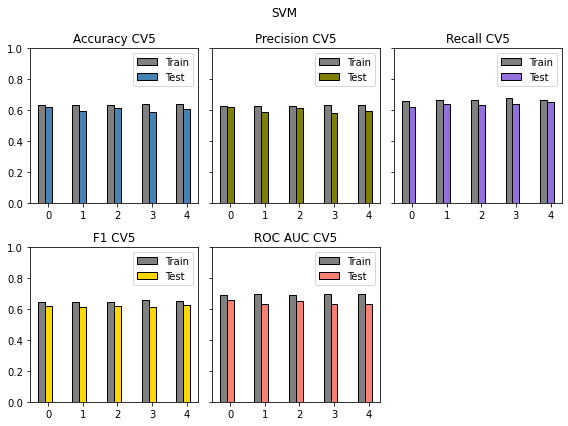

Final model svm SVC(C=1)


In [7]:
# --------- GRID SEARCH SVM -------------
print('--------- SVM Model ---------')

model = SVC()
parameters = {'C':[0.2,1,5], 'kernel':('poly','rbf')}
clf = GridSearchCV(model, parameters, return_train_score = True,scoring ='roc_auc')
clf.fit(X_, y_)

logistic = pd.DataFrame(clf.cv_results_)
logistic.to_csv('SVM_Grid_Search.csv')

print(clf.best_score_)
print(clf.best_params_)

model =  SVC(C = 1, kernel = 'rbf')

results = cross_validate(estimator=model,
                           X=X_,
                           y=y_,
                           cv=5,
                           scoring=_scoring,
                           return_train_score=True,
                           return_estimator = True)

svm_results = pd.DataFrame(results)
#display(svm_results.head())
svm_results.to_csv('SVM_gridSearch_Opt_results.csv')
cvPlot(svm_results,'SVM','Hyperparameter')
model_svm = results['estimator'][0]
print('Final model svm',model_svm)



In [8]:

# FINAL MODELS WITH TEST SET [!]


y_pred_test = model_lr.predict(X_val)
lr_accuracy = accuracy_score(y_val, y_pred_test)
lr_f1= f1_score(y_val, y_pred_test)
lr_roc_auc= roc_auc_score(y_val, y_pred_test)
lr_recall = recall_score(y_val, y_pred_test)
lr_precision = precision_score(y_val, y_pred_test)

print('Logistic')
print(' accuracy', lr_accuracy)
print(' f1',lr_f1)
print(' recall',lr_recall)
print(' precision',lr_precision)
print(' roc_auc',lr_roc_auc)

print('DONE')

print('---- DONE ----')

y_pred_test = model_rf.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_test)
rf_f1= f1_score(y_val, y_pred_test)
rf_roc_auc= roc_auc_score(y_val, y_pred_test)
rf_recall = recall_score(y_val, y_pred_test)
rf_precision = precision_score(y_val, y_pred_test)

print('RF TEST SET')
print(' accuracy',rf_accuracy)
print(' f1',rf_f1)
print(' recall',rf_recall)
print(' precision',rf_precision)
print(' roc_auc',rf_roc_auc)

print('---- DONE ----')

y_pred_test = model_knn.predict(X_val)
knn_accuracy = accuracy_score(y_val, y_pred_test)
knn_f1= f1_score(y_val, y_pred_test)
knn_roc_auc= roc_auc_score(y_val, y_pred_test)
knn_recall = recall_score(y_val, y_pred_test)
knn_precision = precision_score(y_val, y_pred_test)

print('KNN Test SET')
print(' accuracy', knn_accuracy)
print(' f1',knn_f1)
print(' recall',knn_recall)
print(' precision',knn_precision)
print(' roc_auc',knn_roc_auc)

print('---- DONE ----')

y_pred_test = model_svm.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred_test)
svm_f1= f1_score(y_val, y_pred_test)
svm_roc_auc= roc_auc_score(y_val, y_pred_test)
svm_recall = recall_score(y_val, y_pred_test)
svm_precision = precision_score(y_val, y_pred_test)

print('SVM TEST SET')
print(' accuracy', svm_accuracy)
print(' f1',svm_f1)
print(' recall',svm_recall)
print(' precision',svm_precision)
print(' roc_auc',svm_roc_auc)

print('---- DONE ----')

Logistic
 accuracy 0.6009680021511159
 f1 0.5993520518358532
 recall 0.6075533661740559
 precision 0.5913692061800746
 roc_auc 0.6010811228333282
DONE
---- DONE ----
RF TEST SET
 accuracy 0.6138746974993278
 f1 0.5988826815642458
 recall 0.5867542419266557
 precision 0.6115231032515688
 roc_auc 0.6134088334369008
---- DONE ----
KNN Test SET
 accuracy 0.5896746437214305
 f1 0.6013584117032392
 recall 0.6299945265462507
 precision 0.5752123938030984
 roc_auc 0.5903672421314763
---- DONE ----
SVM TEST SET
 accuracy 0.6033880075289056
 f1 0.6027471047670347
 recall 0.6124794745484401
 precision 0.5933191940615058
 roc_auc 0.6035441770205203
---- DONE ----


In [9]:
model_df = pd.read_csv('Models_baseline.csv')
display(model_df.head())

test_roc_auc_val = np.round(np.array([lr_roc_auc,knn_roc_auc,rf_roc_auc,svm_roc_auc]),3)

knn = pd.read_csv('KNN_gridSearch_Opt_results.csv')
SVM = pd.read_csv('SVM_gridSearch_Opt_results.csv')
rf = pd.read_csv('RF_regression_gridSearch_Opt_results.csv')
Log = pd.read_csv('Logistic_regression_gridSearch_Opt_results.csv')

roc_auc_SVM = SVM['test_roc_auc'].mean()
roc_auc_KNN = knn['test_roc_auc'].mean()
roc_auc_RF =  rf['test_roc_auc'].mean()
roc_auc_LOG = Log['test_roc_auc'].mean()

test_opt_roc_auc = np.round(np.array([roc_auc_LOG,roc_auc_KNN,
                                      roc_auc_RF,roc_auc_SVM]),3)
#-----------------
models_names = ['LR','KNN','RF','SVM']
#models_names = ['NB','LR','KNN','RF']
name = 'Models_Baseline_noArtist'
test_roc_auc = round(model_df['test_roc_auc'],2)
print(test_roc_auc)


,Unnamed: 0,Model,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0,LR,0.598023,0.599906,0.598483,0.600070,0.608249,0.609319,0.603164,0.604654,0.624233,0.627437
1,1,KNN,0.554390,0.713745,0.554264,0.708128,0.574777,0.731423,0.564296,0.719586,0.569962,0.780178
2,2,RF,0.596006,0.604629,0.588181,0.595655,0.653369,0.662036,0.618928,0.627064,0.626401,0.638428
3,3,SVM,0.604478,0.635538,0.600427,0.629376,0.637303,0.666923,0.618102,0.647600,0.638259,0.694743


0    0.62
1    0.57
2    0.63
3    0.64
Name: test_roc_auc, dtype: float64


Go


,Unnamed: 0,Model,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0,LR,0.598023,0.599906,0.598483,0.600070,0.608249,0.609319,0.603164,0.604654,0.624233,0.627437
1,1,KNN,0.554390,0.713745,0.554264,0.708128,0.574777,0.731423,0.564296,0.719586,0.569962,0.780178
2,2,RF,0.596006,0.604629,0.588181,0.595655,0.653369,0.662036,0.618928,0.627064,0.626401,0.638428
3,3,SVM,0.604478,0.635538,0.600427,0.629376,0.637303,0.666923,0.618102,0.647600,0.638259,0.694743


(4,)
(4,)
(4,)
Baseline - Train ['lightgrey']
Optimized - Train ['grey']
Optimized - Test ['steelblue', 'olive', 'gold', 'salmon']


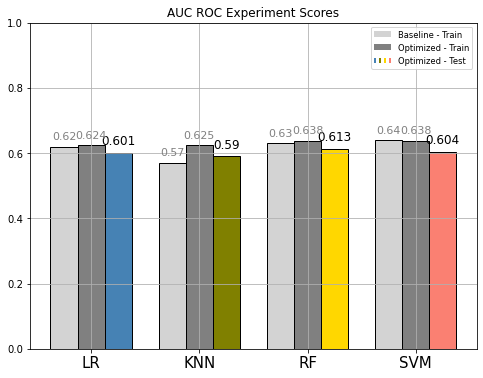

In [10]:
def CreateScoresPlot_AUCROC(name,test_roc_auc,test_opt_roc_auc,
                            test_roc_auc_val,models_names):

    f, axes = plt.subplots(1,sharey=True,figsize = (8,6))
    #f.suptitle('Scores')
    from matplotlib.legend_handler import HandlerTuple
    #test_roc_auc,models_names
    #test_roc_auc_val,models_names
    #test_opt_roc_auc,models_names
    print(test_roc_auc.shape)
    print(test_roc_auc_val.shape)
    print(test_opt_roc_auc.shape)
    
    x = np.arange(0,len(test_roc_auc))
    colors = ['steelblue','olive','gold','salmon']

    bar_b = axes.bar(x-0.5, test_roc_auc, width=0.25, color='lightgrey', align='center', edgecolor = 'black')
    bar_o = axes.bar(x-0.25, test_opt_roc_auc, width=0.25, color='grey', edgecolor = 'black')
    
    #axes[0, 0].bar(x-0.4, model_df['train_accuracy'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes.bar(x, test_roc_auc_val, width=0.25, color=colors, align='center', edgecolor = 'black')
    axes.set_title(name)
    #axes[0, 0].legend(loc="upper right")
    
    new_model_names = []
    nn = -0.5
    n_x = []
    for i in models_names:
        new_model_names.append(i)
        
    axes.set_xticks(np.array(x)-0.25)
    axes.set_xticklabels(new_model_names, fontsize = 15)
    axes.grid()
    import matplotlib.patches as mpatches
    
    
    
    colors = [['lightgrey'],
              ['grey'],
              ['steelblue','olive','gold','salmon'], ]
    categories = ['Baseline - Train','Optimized - Train','Optimized - Test']
    #create dict
    legend_dict=dict(zip(categories,colors))
    #create patches
    patchList = []
    for cat, col in legend_dict.items():
        print(cat,col)
        patchList.append([mpatches.Patch(facecolor=c, label=cat) for c in col])


    plt.gca()
    plt.legend(handles=patchList, labels=categories, ncol=1, fontsize='small',
               handler_map = {list: HandlerTuple(None)})
    

    axes.bar_label(bar,padding=5,fontsize=12, color = 'black')
    axes.bar_label(bar_b,padding=5,fontsize=11, color = 'grey' )
    axes.bar_label(bar_o,padding=5,fontsize=11, color = 'grey')
    plt.ylim([0,1])
    f.savefig('Comparison_results.png')
    plt.show()

print('Go')

model_df = pd.read_csv('Models_baseline.csv')
display(model_df.head())

test_roc_auc_val = np.round(np.array([lr_roc_auc,knn_roc_auc,rf_roc_auc,svm_roc_auc]),3)

knn = pd.read_csv('KNN_gridSearch_Opt_results.csv')
SVM = pd.read_csv('SVM_gridSearch_Opt_results.csv')
rf = pd.read_csv('RF_regression_gridSearch_Opt_results.csv')
Log = pd.read_csv('Logistic_regression_gridSearch_Opt_results.csv')

roc_auc_SVM = SVM['test_roc_auc'].mean()
roc_auc_KNN = knn['test_roc_auc'].mean()
roc_auc_RF =  rf['test_roc_auc'].mean()
roc_auc_LOG = Log['test_roc_auc'].mean()

test_opt_roc_auc = np.round(np.array([roc_auc_LOG,roc_auc_KNN,
                                      roc_auc_RF,roc_auc_SVM]),3)
#-----------------
models_names = ['LR','KNN','RF','SVM']

CreateScoresPlot_AUCROC('AUC ROC Experiment Scores',test_roc_auc,test_opt_roc_auc,
                            test_roc_auc_val,models_names)

0
1
2
3


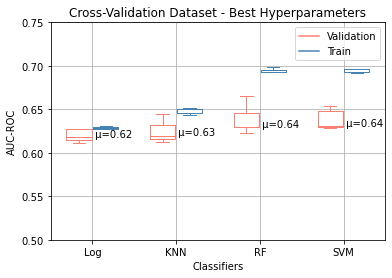

In [11]:
knn = pd.read_csv('KNN_gridSearch_Opt_results.csv')
SVM = pd.read_csv('SVM_gridSearch_Opt_results.csv')
rf = pd.read_csv('RF_regression_gridSearch_Opt_results.csv')
Log = pd.read_csv('Logistic_regression_gridSearch_Opt_results.csv')
xx = [0,2,4,6]
data_s = [Log['test_roc_auc'],
        knn['test_roc_auc'],
        rf['test_roc_auc'],
        SVM['test_roc_auc']]

data_b = [Log['train_roc_auc'],
          knn['train_roc_auc'],
          rf['train_roc_auc'],
          SVM['train_roc_auc']]

labels = ['Log','KNN','RF','SVM']
fig, ax = plt.subplots()

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

c = ['steelblue','olive','gold','salmon']

bpl = plt.boxplot(data_s, positions=np.array(np.arange(len(data_s)))*2.0-0.32, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(np.arange(len(data_b)))*2.0+0.32, sym='', widths=0.6)
set_box_color(bpl, 'salmon') 
set_box_color(bpr, 'steelblue')

m1 = np.array(data_s).mean(axis=1)
st1 = np.array(data_s).std(axis=1)
median = np.median(np.array(data_s), axis = 1)#.median(axis=1)
    
nn = 0
for i, line in enumerate(bpl['medians']):
    print(i)
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}'.format(m1[nn])#, median[i])
    nn = nn+1
    ax.annotate(text, xy=(x, y))

        
ax.set_xticks(xx)
ax.set_xticklabels(labels)

plt.plot([], c='salmon', label='Validation')
plt.plot([], c='steelblue', label='Train')
plt.legend()

plt.xlim(-1,7)
plt.ylim(0.5,0.75)
plt.grid()
plt.title('Cross-Validation Dataset - Best Hyperparameters')
plt.ylabel('AUC-ROC')
plt.xlabel('Classifiers')
fig.savefig('Boxplot_CrossValidation_ParameterSearch.png')
plt.show()




,Accuracy,F1,Recall,Precision,ROC_AUC,Classifiers
0,0.600968,0.599352,0.607553,0.591369,0.601081,LR
1,0.589675,0.601358,0.629995,0.575212,0.590367,KNN
2,0.613875,0.598883,0.586754,0.611523,0.613409,RF
3,0.603388,0.602747,0.612479,0.593319,0.603544,SVM


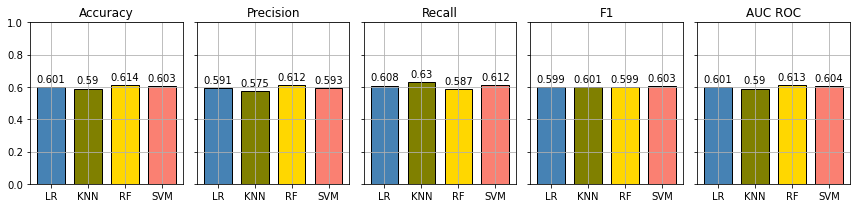

In [12]:

Dict = {'LR':[lr_accuracy,lr_f1,lr_recall,lr_precision,lr_roc_auc],
        'KNN':[knn_accuracy,knn_f1,knn_recall,knn_precision,knn_roc_auc],
        'RF':[rf_accuracy,rf_f1,rf_recall,rf_precision,rf_roc_auc],
        'SVM':[svm_accuracy,svm_f1,svm_recall,svm_precision,svm_roc_auc]}

Final_Scores = pd.DataFrame(Dict#,columns = ['Accuracy','F1','Recall','Precision','ROC_AUC']
                            ).T
Final_Scores.columns = ['Accuracy','F1','Recall','Precision','ROC_AUC'] 
#Final_Scores = Final_Scores.reset_index(drop = True)
Final_Scores['Classifiers'] = Final_Scores.index 
Final_Scores = Final_Scores.reset_index(drop = True)
display(Final_Scores.head())


models_names = ['LR','KNN','RF','SVM']
#models_names = ['NB','LR','KNN','RF']
name = 'Models_Baseline_noArtist'

def CreateScoresPlot(name,model_df,models_names):
    name = 'Models_Finals'
    f, axes = plt.subplots(1, 5,sharey=True,figsize = (12,3))

    x = np.arange(0,len(model_df['Accuracy']))
    colors = ['steelblue','olive','gold','salmon','orange','darkblue','mediumpurple',]
    

    #axes[0, 0].bar(x-0.4, model_df['train_accuracy'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes[0].bar(x,round(model_df['Accuracy'],3), width=0.75, color=colors, align='center',
                        edgecolor = 'black')
    axes[0].set_title('Accuracy')
    #axes[0, 0].legend(loc="upper right")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models_names)
    axes[0].grid()
    axes[0].bar_label(bar,padding=3,fontsize=10, color = 'black')

    #axes[0, 1].bar(x-0.4, model_df['train_precision'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes[1].bar(x, round(model_df['Precision'],3), width=0.75, color=colors, align='center',
                        edgecolor = 'black')
    axes[1].set_title('Precision')
    #axes[0, 1].legend(loc="upper right")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models_names)
    axes[1].grid()
    axes[1].bar_label(bar,padding=3,fontsize=10, color = 'black')

    #axes[0, 2].bar(x-0.4, model_df['train_recall'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes[2].bar(x,round(model_df['Recall'],3), width=0.75, color=colors, align='center',
                        edgecolor = 'black')
    axes[2].set_title('Recall')
    #axes[0, 2].legend(loc="upper right")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(models_names)
    axes[2].grid()
    axes[2].bar_label(bar,padding=3,fontsize=10, color = 'black')

    #axes[1, 0].bar(x-0.4, model_df['train_f1'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes[3].bar(x,round(model_df['F1'],3), width=0.75, color=colors, align='center',
                        edgecolor = 'black')
    axes[3].set_title('F1')
    #axes[1, 0].legend(loc="upper right")
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(models_names)
    axes[3].grid()
    axes[3].bar_label(bar,padding=3,fontsize=10, color = 'black')

    #axes[1, 1].bar(x-0.4, model_df['train_roc_auc'], width=0.4, color='lightgrey', align='center')#, label = 'Train')
    bar = axes[4].bar(x, round(model_df['ROC_AUC'],3), width=0.75, color=colors, align='center',
                        edgecolor = 'black')
    axes[4].set_title('AUC ROC')
    #axes[1, 1].legend(loc="upper right")
    axes[4].set_xticks(x)
    axes[4].set_xticklabels(models_names)
    axes[4].grid()
    axes[4].bar_label(bar,padding=3,fontsize=10, color = 'black')

    plt.legend
    plt.tight_layout()
    #plt.set_xtickslabels(models_names, rotation=65)
    plt.ylim([0,1])
    f.savefig('Results.png')
    plt.show()


CreateScoresPlot(name,Final_Scores,models_names)